## Import

In [1]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 18.9MB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import seaborn as sns
sns.set(font_scale = 2)

from sklearn.model_selection import train_test_split

from IPython.core.display import HTML

import matplotlib.dates as mdates

import os

from sklearn import preprocessing,metrics 
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, average_precision_score, precision_recall_curve

from sklearn import linear_model,svm

from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score

In [123]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)

(233154, 41)
(112392, 40)


In [124]:
df = train.append(test,ignore_index=True)
df.tail()

,AVERAGE.ACCT.AGE,Aadhar_flag,CREDIT.HISTORY.LENGTH,Current_pincode_ID,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,Date.of.Birth,DisbursalDate,Driving_flag,Employee_code_ID,Employment.Type,...,State_ID,UniqueID,VoterID_flag,asset_cost,branch_id,disbursed_amount,loan_default,ltv,manufacturer_id,supplier_id
345541,0yrs 0mon,1,0yrs 0mon,2591,0,14-05-92,28-11-18,0,3823,Self employed,...,4,755547,0,72509,74,44875,NaN,67.58,86,16646
345542,0yrs 0mon,1,0yrs 0mon,2593,0,24-04-84,19-11-18,0,3823,Self employed,...,4,716994,0,72509,74,53549,NaN,78.61,86,16646
345543,4yrs 10mon,1,9yrs 5mon,2593,0,01-01-86,17-11-18,0,3823,Self employed,...,4,709352,0,72509,74,55243,NaN,81.37,86,16646
345544,0yrs 3mon,1,0yrs 3mon,2593,1,01-01-73,15-11-18,0,3823,Self employed,...,4,699795,0,72509,74,55243,NaN,81.37,86,16646
345545,0yrs 0mon,1,0yrs 0mon,2593,0,01-01-74,28-11-18,0,3823,Self employed,...,4,755244,0,72509,74,40274,NaN,60.68,86,16646


## Data Cleaning

In [125]:
print(df.shape)
  
df['DisbursalDate'] =  pd.to_datetime(df['DisbursalDate'], format='%d-%m-%y').dt.day

newdata =  pd.to_datetime(df['Date.of.Birth'], format='%d-%m-%y')
current_year = 2018
newdata.loc[newdata.dt.year.ge(current_year + 1)] -= pd.DateOffset(years=100)
df['Date.of.Birth'] = newdata
df['Date.of.Birth'] = df['Date.of.Birth'].where(df['Date.of.Birth'] < pd.Timestamp('now'), df['Date.of.Birth'] -  np.timedelta64(100, 'Y'))
df['Date.of.Birth'] = (pd.Timestamp('now') - df['Date.of.Birth']).astype('<m8[Y]')  

df['AVERAGE.ACCT.AGE'] = pd.to_numeric(df['AVERAGE.ACCT.AGE'].str.replace(r'(\d+).*(\d+).*', lambda x: '{}.{:0>2}'.format(x[1], x[2])), errors='coerce')
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(lambda x: (math.modf(x)[0]*6)+math.modf(x)[1])
df['CREDIT.HISTORY.LENGTH'] = pd.to_numeric(df['CREDIT.HISTORY.LENGTH'].str.replace(r'(\d+).*(\d+).*', lambda x: '{}.{:0>2}'.format(x[1], x[2])), errors='coerce')
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(lambda x: (math.modf(x)[0]*6)+math.modf(x)[1])

df['PERFORM_CNS.SCORE'] = df['PERFORM_CNS.SCORE'].replace(0, int(df['PERFORM_CNS.SCORE'].mean()))
df['PERFORM_CNS.SCORE.DESCRIPTION'] = df['PERFORM_CNS.SCORE.DESCRIPTION'].map({'No Bureau History Available':6,  
    'I-Medium Risk':9,  'L-Very High Risk':12, 
'A-Very Low Risk':1, 
    'Not Scored: Not Enough Info available on the customer':6, 
'D-Very Low Risk':4,  'M-Very High Risk':13,  'B-Very Low Risk':2,  'C-Very Low Risk':3, 
'E-Low Risk':5,  'H-Medium Risk':8,  'F-Low Risk':6,  'K-High Risk':11, 
'Not Scored: No Activity seen on the customer (Inactive)':6, 
'Not Scored: Sufficient History Not Available':6, 
'Not Scored: No Updates available in last 36 months':6,  'G-Low Risk':7, 
'J-High Risk':10,  'Not Scored: Only a Guarantor':6, 
'Not Scored: More than 50 active Accounts found':10 })
#
df['Employment.Type'].fillna(1, inplace=True)
df['Employment.Type'] = df['Employment.Type'].map({'Salaried':2, 'Self employed':0})
#droplist = ['PERFORM_CNS.SCORE.DESCRIPTION', 'DisbursalDate','Date.of.Birth','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH','UniqueID']
droplist = ['UniqueID','MobileNo_Avl_Flag']
df = df.drop(droplist,axis=1)

print(df.shape)
#print(df.info())

(345546, 41)
(345546, 39)


## Data Preprocessing

In [0]:
ss = preprocessing.StandardScaler()
fields = df.columns.values[:-1]
dfs = pd.DataFrame(ss.fit_transform(df[fields]), columns = fields)
dfs['loan_default'] = df['loan_default']

## Data Sampling

In [127]:
dftrain = dfs[dfs['loan_default'].isnull() != True]
dftest = dfs[dfs['loan_default'].isnull() == True]
dftest.shape

(112392, 38)

In [128]:
loanstatus_0 = dftrain[dftrain["loan_default"]==0]
loanstatus_1 = dftrain[dftrain["loan_default"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=182543)
subset_of_loanstatus_1 = loanstatus_1.sample(n=50611)
dftrain = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
dftrain = dftrain.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",dftrain.shape)
dftrain.head()

Current shape of dataset : (233154, 38)


,AVERAGE.ACCT.AGE,Aadhar_flag,CREDIT.HISTORY.LENGTH,Current_pincode_ID,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,Date.of.Birth,DisbursalDate,Driving_flag,Employee_code_ID,Employment.Type,...,SEC.OVERDUE.ACCTS,SEC.SANCTIONED.AMOUNT,State_ID,VoterID_flag,asset_cost,branch_id,disbursed_amount,loan_default,ltv,manufacturer_id
0,1.970436,0.420328,3.134839,-0.876303,-0.249379,1.658623,-1.310129,-0.146877,-0.201816,-0.885645,...,-0.058918,-0.032393,-0.274244,-0.398682,-0.164785,-0.197040,0.123151,0.0,0.380028,0.776226
1,2.070387,0.420328,0.797054,1.349553,-0.249379,0.644384,0.852989,-0.146877,-0.195959,-0.885645,...,-0.058918,-0.032393,-0.494146,-0.398682,-0.903633,-0.381630,-1.492984,1.0,-1.262895,-1.075450
2,-0.528339,0.420328,-0.537577,0.626495,-0.249379,-1.079823,-0.419434,-0.146877,-0.771901,1.129121,...,-0.058918,-0.032393,0.165559,-0.398682,0.214219,-0.878605,0.179567,0.0,-0.184699,2.311763
3,-0.528339,0.420328,-0.537577,-0.115754,-0.249379,-0.471279,1.489200,-0.146877,0.077370,NaN,...,-0.058918,-0.032393,1.484969,-0.398682,0.605977,-0.836007,0.977517,1.0,0.334956,0.776226
4,0.504488,0.420328,0.517916,0.202034,-0.249379,-1.384095,0.725746,-0.146877,0.833905,NaN,...,-0.058918,-0.032393,0.165559,-0.398682,0.733307,0.867906,1.203947,0.0,0.445426,-0.939962


In [0]:
X ,y = dftrain.drop('loan_default',axis=1), dftrain['loan_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.13, random_state=42)

## Plotting Modules

In [0]:
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")

In [0]:
def plot_confusion_matrix(model, normalize=False):
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Model

In [0]:
def cross_val(X_train, y_train, model):
  
  accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
  return accuracies.mean()

def fit_and_evaluate(model):
    
  model.fit(X_train, y_train)

  model_pred = model.predict(X_test)
  predictproba = model.predict_proba(X_test)[:,1]
  model_cross = cross_val(X_train, y_train, model)
  print("Train Accuracy: ",accuracy_score(y_train, model.predict(X_train)))
  print("Test Accuracy: ",accuracy_score(y_test, model_pred))
  print("Confusion Matrix: ")
  conf = confusion_matrix(y_test, model_pred)
  plotAUC(y_test,predictproba, "model")
  plt.show()
  plt.figure(figsize=(6,6))
  plot_confusion_matrix(model_pred, normalize=True)
  plt.show()
  return model_cross

Train Accuracy:  0.7885803306005137
Test Accuracy:  0.784830589554947
Confusion Matrix: 


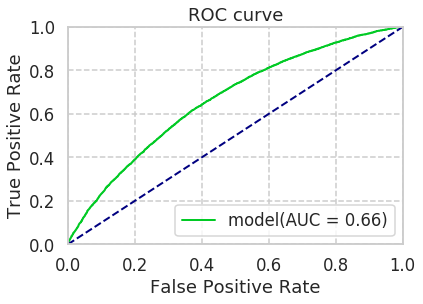

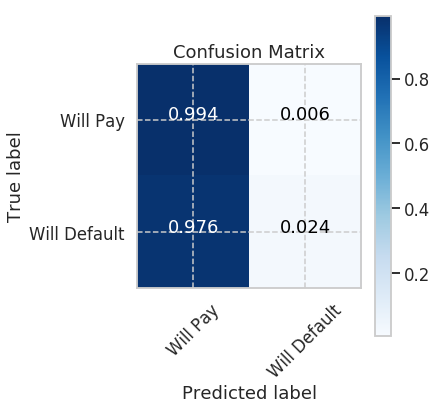

Gradient Boosting Classification Performance on the test set: Cross Validation Score = 0.7830


In [133]:
gb = XGBClassifier(eval_metric='auc',learning_rate = 0.1,
 n_estimators=200,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=47,verbosity=1)
gb_cross = fit_and_evaluate(gb)

print('Gradient Boosting Classification Performance on the test set: Cross Validation Score = %0.4f' % gb_cross)

## Evaluate Model

In [134]:
trained_model = gb
predictions = trained_model.predict(X_test) 
print("Train Accuracy: ",accuracy_score(y_train, trained_model.predict(X_train)))
print("Test Accuracy: ",accuracy_score(y_test, predictions))
print("Confusion Matrix: ")
conf = confusion_matrix(y_test, predictions)
print(conf)
conf1 = (conf / conf.astype(np.float).sum(axis=1))*100
x = conf.sum().sum()
print(conf1)
conf2 = (conf / conf.astype(np.float).sum(axis=0))*100
print(conf2)
conf3 = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
print((conf/x)*100)

Train Accuracy:  0.7885803306005137
Test Accuracy:  0.784830589554947
Confusion Matrix: 
[[23633   151]
 [ 6371   156]]
[[99.36511941  2.31346714]
 [26.78691557  2.39007201]]
[[78.76616451 49.18566775]
 [21.23383549 50.81433225]]
[[77.96839431  0.49816898]
 [21.01877206  0.51466464]]


## Applying model



In [135]:
dftest.head()

,AVERAGE.ACCT.AGE,Aadhar_flag,CREDIT.HISTORY.LENGTH,Current_pincode_ID,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,Date.of.Birth,DisbursalDate,Driving_flag,Employee_code_ID,Employment.Type,...,SEC.OVERDUE.ACCTS,SEC.SANCTIONED.AMOUNT,State_ID,VoterID_flag,asset_cost,branch_id,disbursed_amount,loan_default,ltv,manufacturer_id
233154,-0.528339,0.420328,-0.537577,-0.792393,-0.249379,1.050080,-2.073582,-0.146877,0.367294,1.129121,...,-0.058918,-0.032393,-0.274244,-0.398682,-0.679711,-0.111844,-0.110255,NaN,1.026061,-1.075450
233155,-0.128535,0.420328,-0.101423,-0.792393,-0.249379,-0.167008,0.089535,-0.146877,0.367294,-0.885645,...,-0.058918,-0.032393,-0.274244,-0.398682,-0.700790,-0.111844,0.045732,NaN,1.283237,-1.075450
233156,-0.528339,0.420328,-0.537577,-0.536198,-0.249379,-1.181247,1.234715,-0.146877,0.023681,1.129121,...,-0.058918,-0.032393,-0.714047,-0.398682,0.428269,0.044348,0.794548,NaN,0.441891,0.776226
233157,1.387388,0.420328,0.465577,-0.536645,-0.249379,1.050080,1.234715,-0.146877,0.023681,-0.885645,...,-0.058918,-0.032393,-0.714047,-0.398682,-0.661673,0.044348,-0.614090,NaN,0.145829,-1.075450
233158,-0.528339,0.420328,-0.537577,-0.537091,-0.249379,1.151504,-0.292191,-0.146877,0.023681,1.129121,...,-0.058918,-0.032393,-0.714047,-0.398682,-0.661673,0.044348,-0.267392,NaN,0.985408,-1.075450


In [0]:
dftest.drop('loan_default', axis=1, inplace=True)
test_y = gb.predict_proba(dftest)[:,1]

In [137]:
test_y.size

112392

## Submission

In [138]:
submission = pd.DataFrame()
submission['UniqueID'] = test['UniqueID']
submission['loan_default'] = test_y

submission.loan_default.value_counts().head(10)

0.299699    4
0.353311    4
0.480599    3
0.110122    3
0.265650    3
0.214675    3
0.257577    3
0.317573    2
0.094279    2
0.364588    2
Name: loan_default, dtype: int64

In [139]:
print(submission.shape)
submission.to_csv('submission.csv', index=False)

(112392, 2)
